In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AR
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import statsmodels.api as sm
from hmmlearn.hmm import GaussianHMM
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
m = Prophet()

from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
scaler = StandardScaler()

from itertools import product
from tqdm import tqdm_notebook

import warnings                                  
warnings.filterwarnings('ignore')

Using TensorFlow backend.
INFO:gluonts.core.component:Using CPU


### Quality metrics

In [12]:
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score,  mean_poisson_deviance

def mean_absolute_percentage_error(y_true, y_pred): 
    
    """
        y_true - actual values
        y_pred - predicted values
    """
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
def quality_metrics(actual, preds):
    
    """
        actual - actual values
        preds - predicted values
    """
    
    mape = mean_absolute_percentage_error(actual, preds)
    evs = explained_variance_score(actual, preds)
    maxerror = max_error(actual, preds)
    mae = mean_absolute_error(actual, preds)
    mse = mean_squared_error(actual, preds)
    msle = mean_squared_log_error(actual, preds)
    r2 = r2_score(actual, preds)
    mpd = mean_poisson_deviance(actual, preds)
    
    return mape, evs, maxerror, mae, mse, msle, r2, mpd

In [14]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [15]:
def split(data, size=0.3):
    
    train, test = data[0:len(data)-round(len(data)*size)], data[len(data)-round(len(data)*size):]
    
    return train, test

### Data preparation

In [16]:
def format_data(data, column_name, start_drop=86401, end_drop=1048503):
    
    """
        data - dataset with timeseries
        column_name - Motor parameter name
        start_drop - reference point for deleting data from the source dataset
        end_drop - the endpoint for deleting data from the source dataset
    """
    
    data = pd.read_csv(data, header=None)
    data.drop(data.columns[[1,3,4]], axis=1, inplace=True)
    data.columns = ['datetime', column_name]
    data_ = pd.to_datetime(data['datetime'])
    data__ = pd.DataFrame(data[column_name].values, index=data_, columns=[column_name])
    data__.drop(data__.index[start_drop:end_drop], inplace=True)
    data__ = data__.resample('T').ffill()
    
    return data__

In [17]:
def plotModel(actual_1, actual_2, actual_3, actual_4, model_1, 
                model_2, model_3, model_4, name_model, 
                sd_mse=None, sd_mape=None, sd_maxerror=None, cu_mse=None, 
                cu_mape=None, cu_maxerror=None, te_mse=None, te_mape=None, 
                te_maxerror=None, nm_mse=None, nm_mape=None, nm_maxerror=None, 
                predictive_mode=False):
    """
        actual - actual motor parameter values
        model - predicted motor parameter values
    """
    with plt.style.context('seaborn-white'):

        f, axs = plt.subplots(2,2,figsize=(20,10))
        
        ax1 = plt.subplot(221)
        ax1.set_ylabel('Motor speed (M/MN)', fontsize=15)
        ax1.plot(model_1, linewidth=2, color='red', label='Model')
        ax1.plot(actual_1, linewidth=2, color='blue', label='Actual')
        ax1.legend(['Model', 'Actual'])
        ax1.grid(True)
                                                                 
        ax2 = plt.subplot(222)
        ax2.set_ylabel('Motor current (А)', fontsize=15)
        ax2.plot(model_2, linewidth=2, color='red', label='Model')
        ax2.plot(actual_2, linewidth=0.5, color='blue', label='Actual')
        ax2.legend(['Model', 'Actual'])
        ax2.grid(True)

        ax3 = plt.subplot(223)
        ax3.set_ylabel('Motor temperature (°C)', fontsize=15)
        ax3.plot(model_3, linewidth=2, color='red', label='Model')
        ax3.set_xlabel('Time (h)', fontsize=15)
        ax3.plot(actual_3, linewidth=0.5, color='blue', label='Actual')
        ax3.legend(['Model', 'Actual'])
        ax3.grid(True)

        ax4 = plt.subplot(224)
        ax4.set_ylabel('Motor torque (Nm)', fontsize=15)
        ax4.set_xlabel('Time (h)', fontsize=15)
        ax4.plot(model_4, linewidth=2, color='red', label='Model')
        ax4.plot(actual_4, linewidth=0.5, color='blue', label='Actual')
        ax4.legend(['Model', 'Actual'])
        ax4.grid(True)
              
        if predictive_mode:
            
            ax1.set_title(f'Motor speed ({name_model})\n MSE: {sd_mse:.{2}f},'
                            f'MAPE: {sd_mape:.{2}f}, MAX_ERROR: {sd_maxerror:.{2}f}', fontsize=15)
            ax1.vlines(model_1[0:1].index, ymin=410, ymax=440, linestyles='dashed')
            ax1.axvspan(model_1[0:1].index, actual_1[len(actual_1)-1:].index, alpha=0.3, color='lightgrey')                                                  
            
            ax2.set_title(f'Motor current ({name_model})\n MSE: {cu_mse:.{2}f},'
                            f'MAPE: {cu_mape:.{2}f}, MAX_ERROR: {cu_maxerror:.{2}f}', fontsize=15)
            ax2.vlines(model_2[0:1].index, ymin=115, ymax=125, linestyles='dashed')
            ax2.axvspan(model_2[0:1].index, actual_2[len(actual_2)-1:].index, alpha=0.3, color='lightgrey')
            
            ax3.set_title(f'Motor temperature ({name_model})\n MSE: {te_mse:.{2}f},'
                            f'MAPE: {te_mape:.{2}f}, MAX_ERROR: {te_maxerror:.{2}f}', fontsize=15)
            ax3.vlines(model_3[0:1].index, ymin=40, ymax=45, linestyles='dashed')
            ax3.axvspan(model_3[0:1].index, actual_3[len(actual_3)-1:].index, alpha=0.3, color='lightgrey')
            
            ax4.set_title(f'Motor torque ({name_model})\n MSE: {nm_mse:.{2}f},'
                        f'MAPE: {nm_mape:.{2}f}, MAX_ERROR: {nm_maxerror:.{2}f}', fontsize=15)
            ax4.vlines(model_4[0:1].index, ymin=278, ymax=298, linestyles='dashed')
            ax4.axvspan(model_4[0:1].index, actual_4[len(actual_4)-1:].index, alpha=0.3, color='lightgrey')

        else:
                                                                 
            ax1.set_title(f'Motor speed ({name_model})', fontsize=15)
            ax2.set_title(f'Motor current ({name_model})', fontsize=15)
            ax3.set_title(f'Motor temperature ({name_model})', fontsize=15)
            ax4.set_title(f'Motor torque ({name_model})', fontsize=15)
                                                             
        plt.show()

#### load datasets

In [19]:
data_ts_sd_m = format_data('datasets/AI_SD.csv', 'Motor speed')
data_ts_cu_m = format_data('datasets/AI_CU.csv', 'Current')
data_ts_te_m = format_data('datasets/AI_TE.csv', 'Temperature')
data_ts_nm_m = format_data('datasets/AI_Nm.csv', 'Torque')

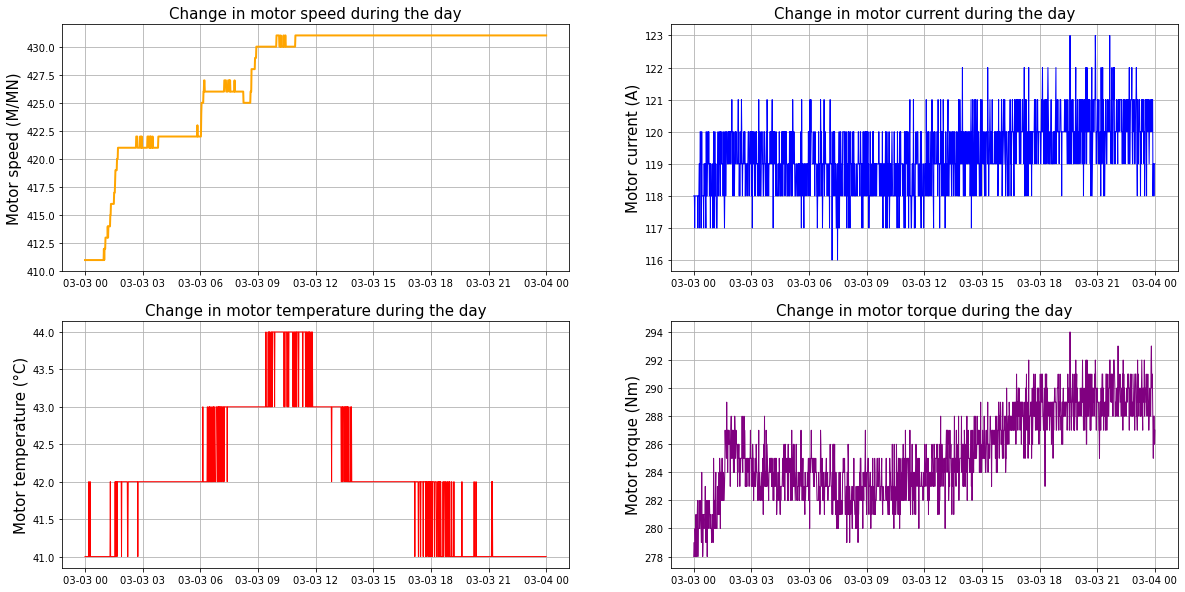

In [20]:
with plt.style.context('seaborn-deep'):
    
    f, axs = plt.subplots(2,2,figsize=(20,10))

    ax1 = plt.subplot(221)
    ax1.set_ylabel('Motor speed (M/MN)', fontsize=15)
    ax1.plot(data_ts_sd_m, linewidth=2, color='orange')
    ax1.set_title('Change in motor speed during the day', fontsize=15)

    ax2 = plt.subplot(222)
    ax2.set_ylabel('Motor current (А)', fontsize=15)
    ax2.plot(data_ts_cu_m, linewidth=1, color='blue')
    ax2.set_title('Change in motor current during the day', fontsize=15)
    
    ax3 = plt.subplot(223)
    ax3.set_ylabel('Motor temperature (°C)', fontsize=15)
    ax3.plot(data_ts_te_m, linewidth=1, color='red')
    ax3.set_title('Change in motor temperature during the day', fontsize=15)
    
    ax4 = plt.subplot(224)
    ax4.set_ylabel('Motor torque (Nm)', fontsize=15)
    ax4.plot(data_ts_nm_m, linewidth=1, color='purple')
    ax4.set_title('Change in motor torque during the day', fontsize=15)
    
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    plt.show()

### Moving average

In [21]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

print(f"Rolling mean (motor speed): {moving_average(data_ts_sd_m, 1441)}\n"
      f"Rolling mean (motor current): {moving_average(data_ts_cu_m, 1441)}\n" 
      f"Rolling mean (motor temperature): {moving_average(data_ts_te_m, 1441)}\n" 
      f"Rolling mean (motor torque): {moving_average(data_ts_nm_m, 1441)}")


Rolling mean (motor speed): 427.3448993754337
Rolling mean (motor current): 119.29562803608606
Rolling mean (motor temperature): 42.05204718945177
Rolling mean (motor torque): 285.381679389313


In [22]:
%%time

rolling_mean_sd = data_ts_sd_m.rolling(window=50).mean()
rolling_mean_cu = data_ts_cu_m.rolling(window=50).mean()
rolling_mean_te = data_ts_te_m.rolling(window=50).mean()
rolling_mean_nm = data_ts_nm_m.rolling(window=50).mean()

Wall time: 5.98 ms


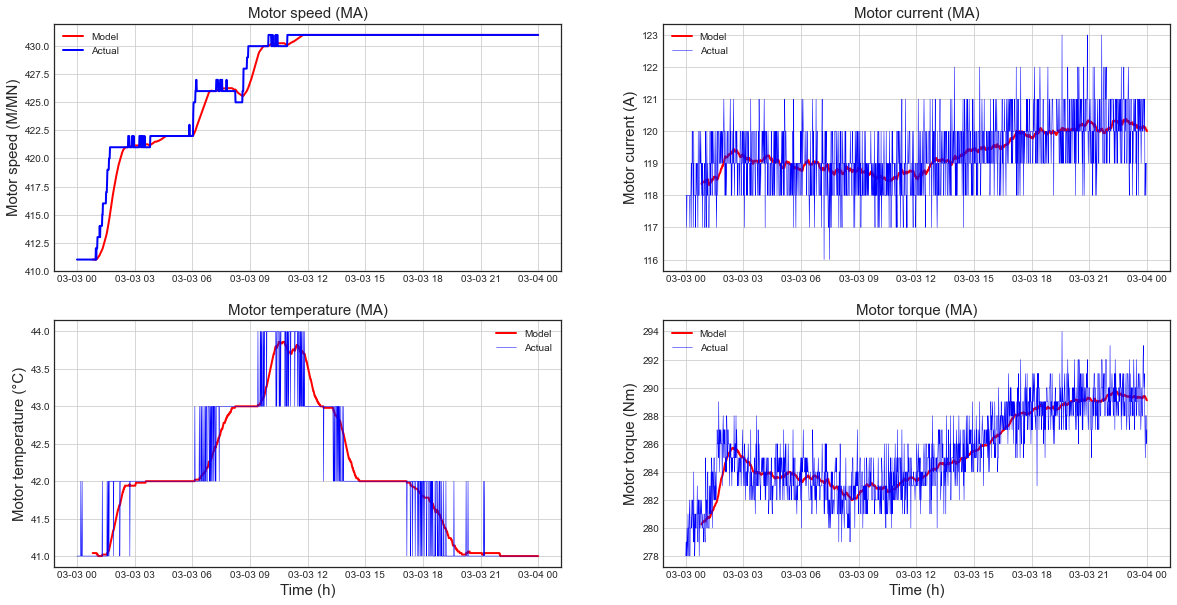

In [23]:
plotModel(data_ts_sd_m['Motor speed'], 
            data_ts_cu_m['Current'], 
            data_ts_te_m['Temperature'], 
            data_ts_nm_m['Torque'], 
            rolling_mean_sd, 
            rolling_mean_cu, 
            rolling_mean_te, 
            rolling_mean_nm, 
            'MA', predictive_mode=False)

### Weighted moving average

In [24]:
%%time

def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

print(f"weighter average (motor speed): {weighted_average(data_ts_sd_m, [0.6, 0.3, 0.1])}\n"
      f"weighter average (motor current): {weighted_average(data_ts_cu_m, [0.6, 0.3, 0.1])}\n" 
      f"weighter average (motor temperature): {weighted_average(data_ts_te_m, [0.6, 0.3, 0.1])}\n" 
      f"weighter average (motor torque): {weighted_average(data_ts_nm_m, [0.6, 0.3, 0.1])}")

weighter average (motor speed): 430.99999999999994
weighter average (motor current): 118.99999999999999
weighter average (motor temperature): 41.0
weighter average (motor torque): 287.29999999999995
Wall time: 8.94 ms


### Exponential smoothing

In [25]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    
    model = pd.Series(result, index=series.index)
    
    return model

In [26]:
%%time

exp_smt_sd = exponential_smoothing(data_ts_sd_m['Motor speed'], 0.07)
exp_smt_cu = exponential_smoothing(data_ts_cu_m['Current'], 0.07)
exp_smt_te = exponential_smoothing(data_ts_te_m['Temperature'], 0.07)
exp_smt_nm = exponential_smoothing(data_ts_nm_m['Torque'], 0.07)

Wall time: 255 ms


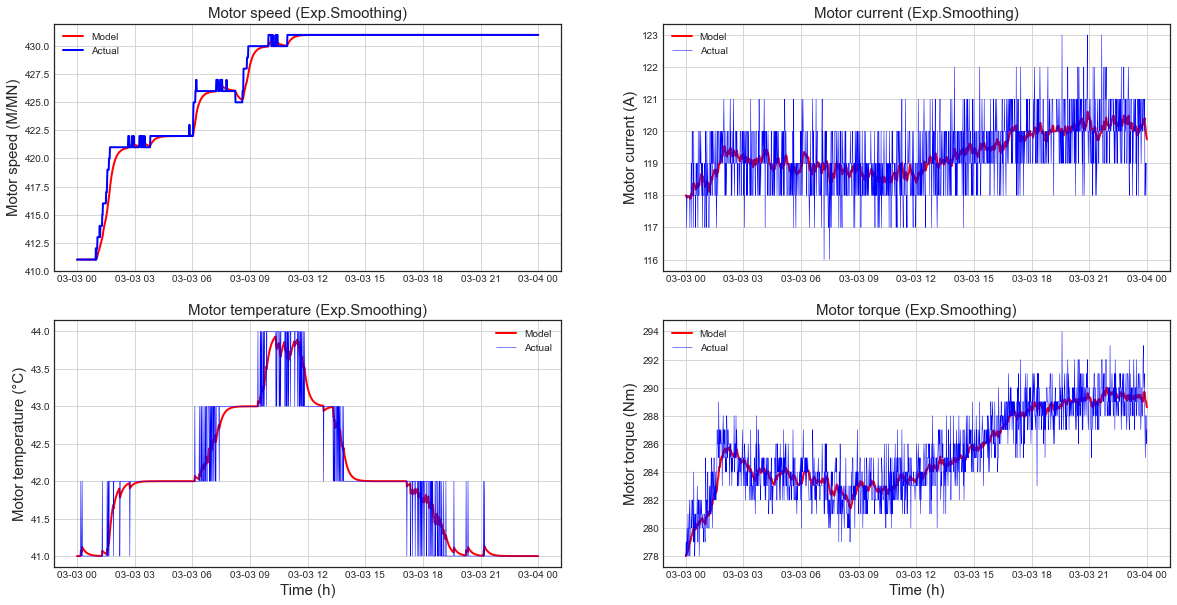

In [27]:
plotModel(data_ts_sd_m['Motor speed'], 
            data_ts_cu_m['Current'], 
            data_ts_te_m['Temperature'], 
            data_ts_nm_m['Torque'], 
            exp_smt_sd, 
            exp_smt_cu, 
            exp_smt_te, 
            exp_smt_nm, 
            'Exp.Smoothing', predictive_mode=False)

### Double exponential smoothing

In [28]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    
    model = pd.Series(result[:1441], index=series.index)
    
    return model

In [29]:
%%time

dbl_exp_smt_sd = double_exponential_smoothing(data_ts_sd_m['Motor speed'], 0.03, 0.9)
dbl_exp_smt_cu = double_exponential_smoothing(data_ts_cu_m['Current'], 0.03, 0.9)
dbl_exp_smt_te = double_exponential_smoothing(data_ts_te_m['Temperature'], 0.3, 0.9)
dbl_exp_smt_nm = double_exponential_smoothing(data_ts_nm_m['Torque'], 0.03, 0.9)

Wall time: 427 ms


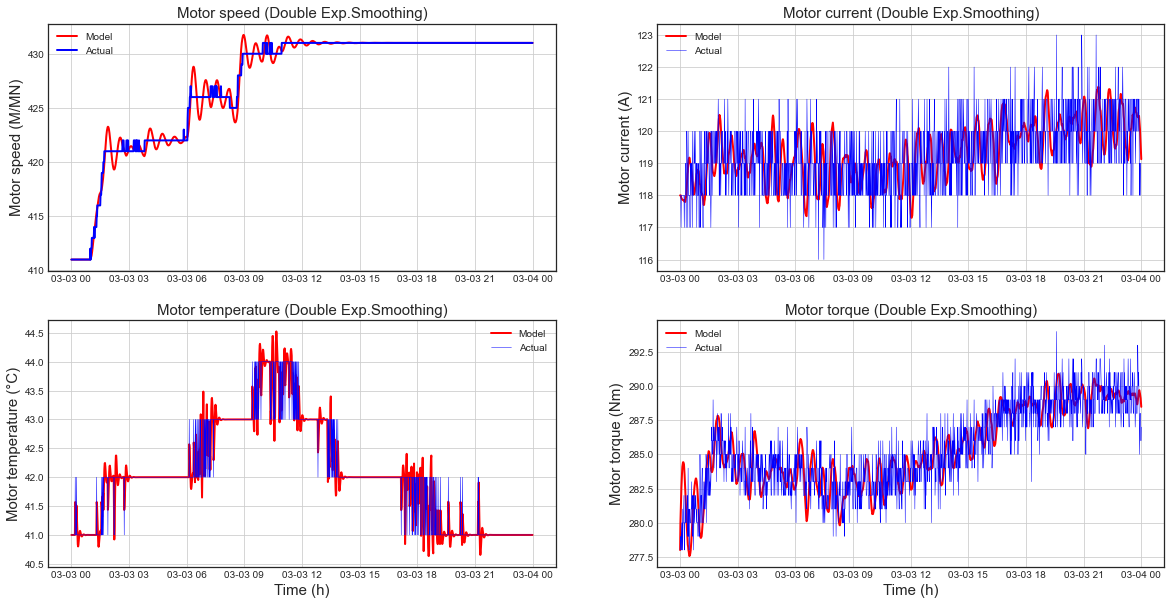

In [30]:
plotModel(data_ts_sd_m['Motor speed'], 
            data_ts_cu_m['Current'], 
            data_ts_te_m['Temperature'], 
            data_ts_nm_m['Torque'], 
            dbl_exp_smt_sd, 
            dbl_exp_smt_cu, 
            dbl_exp_smt_te, 
            dbl_exp_smt_nm, 
            'Double Exp.Smoothing', predictive_mode=False)

### Holt-Winters

In [31]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    tscv = TimeSeriesSplit(n_splits=3) 

    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [32]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
   
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: 
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): 
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [33]:
def selection_of_parameters(data, leave_data_for_testing=400, n_preds=400):
     
    train = data[:-leave_data_for_testing]
    test = data[len(data)-leave_data_for_testing:]
    x = [0, 0, 0]
    
    opt = minimize(timeseriesCVscore, x0=x, 
               args=(train, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )
    
    alpha_final, beta_final, gamma_final = opt.x
    
    model = HoltWinters(train, slen = 12, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = n_preds, scaling_factor = 3)
    model.triple_exponential_smoothing()
    
    hw_model = pd.Series(model.result[1041:], index=data[len(data)-leave_data_for_testing:].index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(test.values, hw_model.values)
        
    return hw_model, mse, mape, maxerror

In [34]:
%%time

model_hw_speed, sd_hw_mse, sd_hw_mape, sd_hw_maxerror = selection_of_parameters(data_ts_sd_m['Motor speed'], 
                                                                                leave_data_for_testing=400, 
                                                                                n_preds=400)

model_hw_current, cu_hw_mse, cu_hw_mape, cu_hw_maxerror, = selection_of_parameters(data_ts_cu_m['Current'], 
                                                                                   leave_data_for_testing=400, 
                                                                                   n_preds=400)

model_hw_temperature, te_hw_mse, te_hw_mape, te_hw_maxerror = selection_of_parameters(data_ts_te_m['Temperature'], 
                                                                                      leave_data_for_testing=400, 
                                                                                      n_preds=400)

model_hw_torque, nm_hw_mse, nm_hw_mape, nm_hw_maxerror = selection_of_parameters(data_ts_nm_m['Torque'], 
                                                                                 leave_data_for_testing=400, 
                                                                                 n_preds=400)

Wall time: 1min 19s


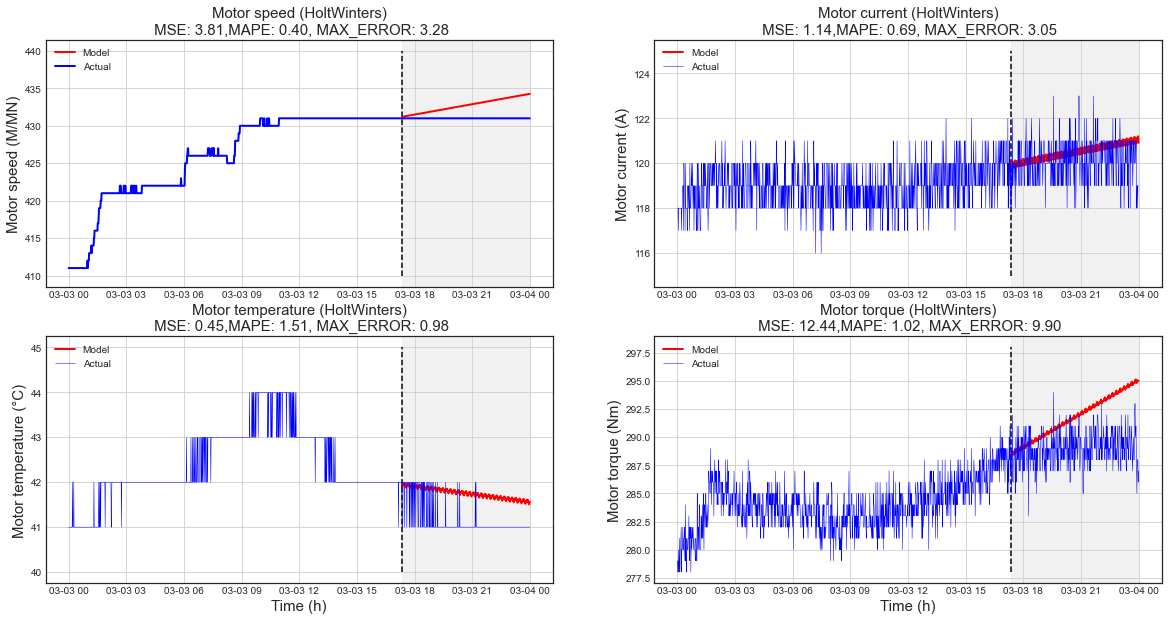

In [35]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          model_hw_speed, 
          model_hw_current, 
          model_hw_temperature, 
          model_hw_torque, 
          'HoltWinters', 
          sd_hw_mse, sd_hw_mape, sd_hw_maxerror, 
          cu_hw_mse, cu_hw_mape, cu_hw_maxerror,
          te_hw_mse, te_hw_mape, te_hw_maxerror, 
          nm_hw_mse, nm_hw_mape, nm_hw_maxerror,
          predictive_mode=True)

## Autoregressive models
### AR 

In [36]:
def ar_model(data):
    
    train, test = split(data, size=0.3)
    model = AR(train)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(test.values, predictions.values)
    
    return predictions, mape, mse, maxerror

In [37]:
%%time

ar_sd_predictions, sd_ar_mape, sd_ar_mse, sd_ar_maxerror = ar_model(data_ts_sd_m)
ar_cu_predictions, cu_ar_mape, cu_ar_mse, cu_ar_maxerror = ar_model(data_ts_cu_m)
ar_te_predictions, te_ar_mape, te_ar_mse, te_ar_maxerror = ar_model(data_ts_te_m)
ar_nm_predictions, nm_ar_mape, nm_ar_mse, nm_ar_maxerror = ar_model(data_ts_nm_m)

Wall time: 96.8 ms


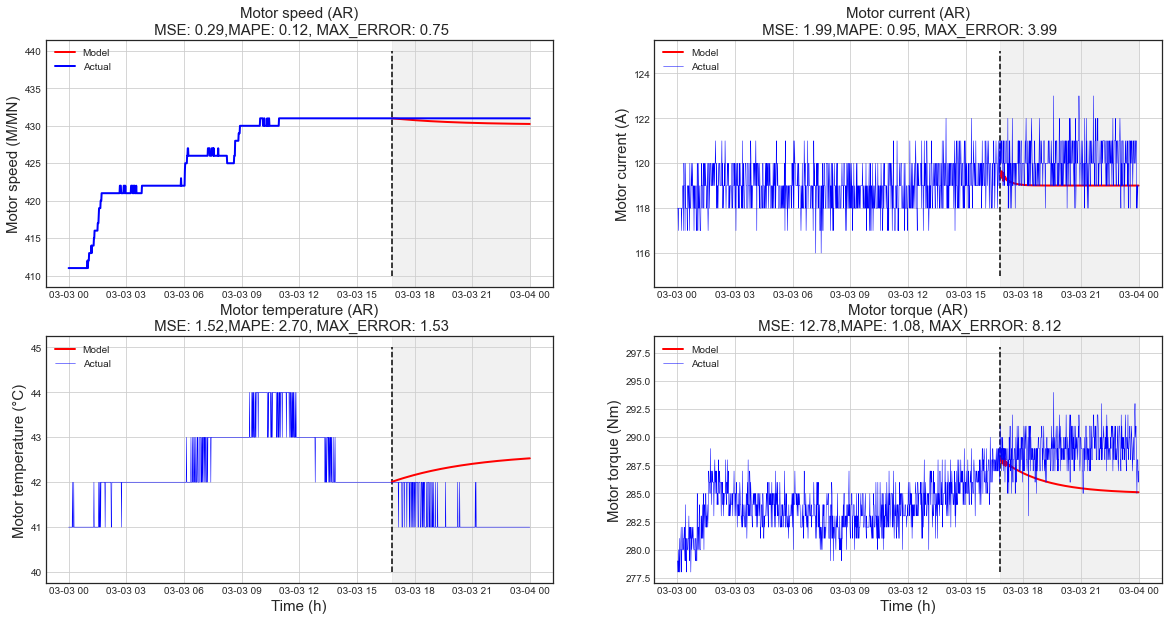

In [38]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          ar_sd_predictions, 
          ar_cu_predictions, 
          ar_te_predictions, 
          ar_nm_predictions, 
          'AR', 
          sd_ar_mse, sd_ar_mape, sd_ar_maxerror, 
          cu_ar_mse, cu_ar_mape, cu_ar_maxerror,
          te_ar_mse, te_ar_mape, te_ar_maxerror, 
          nm_ar_mse, nm_ar_mape, nm_ar_maxerror,
          predictive_mode=True)

### ARIMA

In [39]:
def arima(data, start_p=2, start_q=2, start_d=1, max_p=2, max_q=2, max_d=1):
    
    train, test = split(data)
    
    model = pm.auto_arima(train, start_p=start_p, start_q=start_q, max_p=max_p, max_q=max_q, start_d=start_d, max_d=max_d)
    forecasts = model.predict(test.shape[0])
    forecasts = pd.Series(forecasts, index=data[len(train):].index)
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(test.values, forecasts.values)
    
    return forecasts, test, mse, mape, maxerror 

In [40]:
%%time

sd_arima_predictions, sd_arima_test, sd_arima_mse, sd_arima_mape, sd_arima_maxerror = arima(data_ts_sd_m)
cu_arima_predictions, cu_arima_test, cu_arima_mse, cu_arima_mape, cu_arima_maxerror = arima(data_ts_cu_m)
te_arima_predictions, te_arima_test, te_arima_mse, te_arima_mape, te_arima_maxerror = arima(data_ts_te_m)
nm_arima_predictions, nm_arima_test, nm_arima_mse, nm_arima_mape, nm_arima_maxerror = arima(data_ts_nm_m)

Wall time: 12.5 s


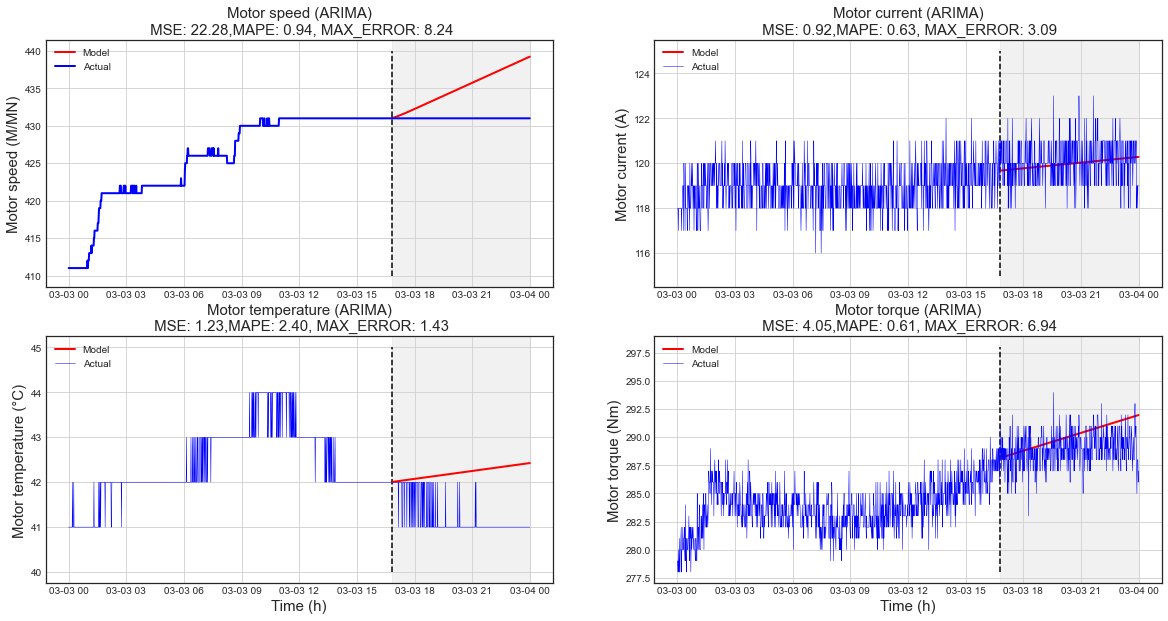

In [41]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_arima_predictions, 
          cu_arima_predictions, 
          te_arima_predictions, 
          nm_arima_predictions, 
          'ARIMA', 
          sd_arima_mse, sd_arima_mape, sd_arima_maxerror, 
          cu_arima_mse, cu_arima_mape, cu_arima_maxerror,
          te_arima_mse, te_arima_mape, te_arima_maxerror, 
          nm_arima_mse, nm_arima_mape, nm_arima_maxerror,
          predictive_mode=True)

### SARIMA

In [42]:
def SARIMA(data, p=2, q=3, P=0, Q=1, d=1, D=1, s=6):
    
    """
    p, q, P, Q, d, D, s - parameters to customize the model
    """
    
    train, test = split(data)
    
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                      seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    forecast = model.forecast(steps=432)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(test.values, forecast.values)
    
    return forecast, mape, mse, maxerror

In [43]:
%%time

sd_sarima_predictions, sd_sar_mape, sd_sar_mse, sd_sar_maxerror = SARIMA(data_ts_sd_m['Motor speed'])
cu_sarima_predictions, cu_sar_mape, cu_sar_mse, cu_sar_maxerror = SARIMA(data_ts_cu_m['Current'])
te_sarima_predictions, te_sar_mape, te_sar_mse, te_sar_maxerror = SARIMA(data_ts_te_m['Temperature'])
nm_sarima_predictions, nm_sar_mape, nm_sar_mse, nm_sar_maxerror = SARIMA(data_ts_nm_m['Torque'])

Wall time: 16.5 s


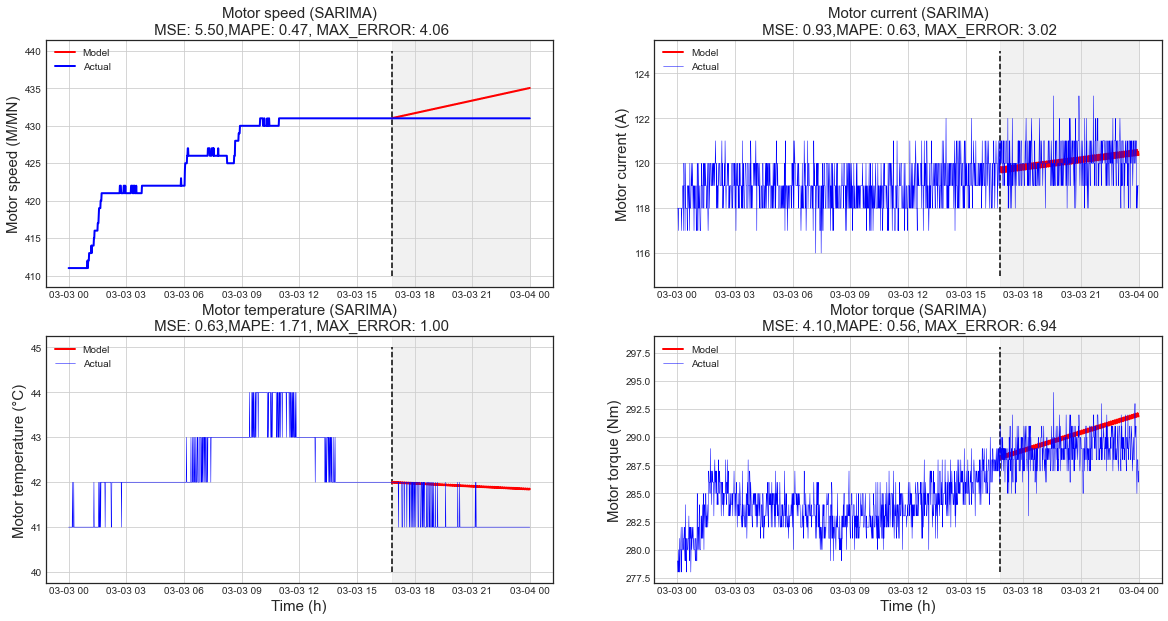

In [44]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_sarima_predictions, 
          cu_sarima_predictions, 
          te_sarima_predictions, 
          nm_sarima_predictions, 
          'SARIMA', 
          sd_sar_mse, sd_sar_mape, sd_sar_maxerror, 
          cu_sar_mse, cu_sar_mape, cu_sar_maxerror,
          te_sar_mse, te_sar_mape, te_sar_maxerror, 
          nm_sar_mse, nm_sar_mape, nm_sar_maxerror,
          predictive_mode=True)

## Hidden Markov Model

In [45]:
def HMM(data, n_components=20, n_iter=1000):
    
    """
        n_components - number of states
    """
    
    train, test = split(data)
    
    model = GaussianHMM(n_components=n_components,
                        covariance_type="diag",
                        n_iter=n_iter)
    
    HMM = model.fit(data)
    labels = model.predict(data)
    means = np.zeros_like(data)
    
    for i in range(model.n_components):
        means[labels == i] = model.means_[i]
    
    dataframe = pd.DataFrame(means)
    new_dataframe = dataframe.iloc[:,0].values
    
    forecast = pd.Series(new_dataframe[1009:], index=test.index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(test.values, forecast.values)

    return forecast, mse, mape, maxerror

In [46]:
%%time

sd_hmm_predictions, sd_hmm_mape, sd_hmm_mse, sd_hmm_maxerror = HMM(data_ts_sd_m)
cu_hmm_predictions, cu_hmm_mape, cu_hmm_mse, cu_hmm_maxerror = HMM(data_ts_cu_m)
te_hmm_predictions, te_hmm_mape, te_hmm_mse, te_hmm_maxerror = HMM(data_ts_te_m)
nm_hmm_predictions, nm_hmm_mape, nm_hmm_mse, nm_hmm_maxerror = HMM(data_ts_nm_m)

Wall time: 13.8 s


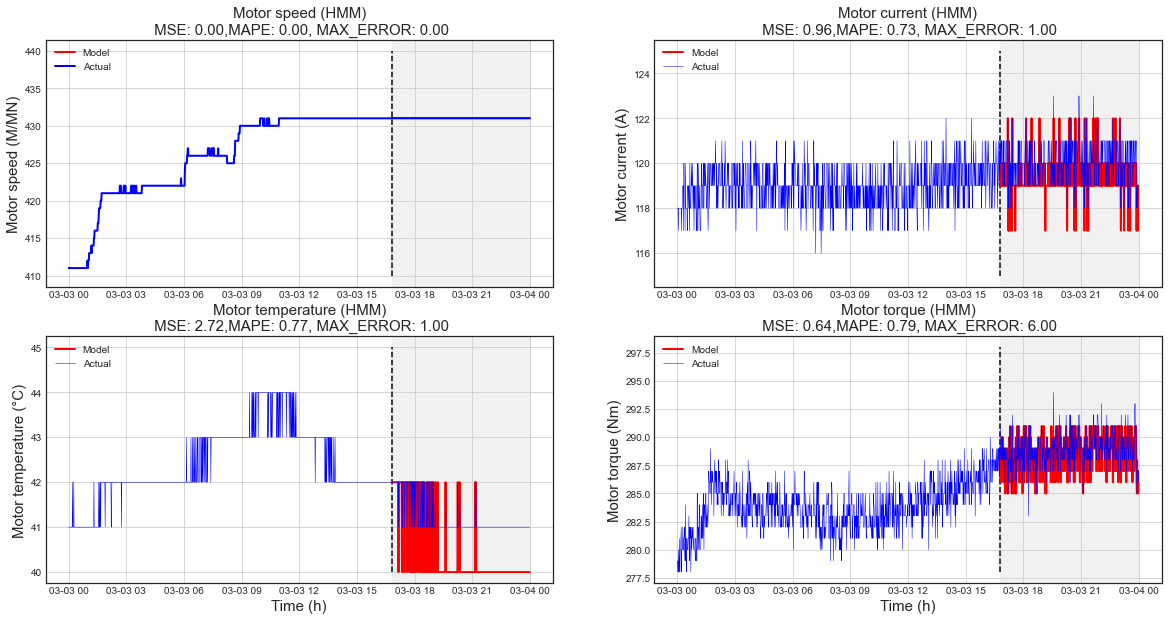

In [47]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_hmm_predictions, 
          cu_hmm_predictions, 
          te_hmm_predictions, 
          nm_hmm_predictions, 
          'HMM', 
          sd_hmm_mse, sd_hmm_mape, sd_hmm_maxerror, 
          cu_hmm_mse, cu_hmm_mape, cu_hmm_maxerror,
          te_hmm_mse, te_hmm_mape, te_hmm_maxerror, 
          nm_hmm_mse, nm_hmm_mape, nm_hmm_maxerror,
          predictive_mode=True)

## Linear Regression

In [48]:
def linear_regression(data, start, end):
    
    data_ = pd.DataFrame(data.copy())
    data_.columns = ["y"]
    
    # shift the time series to add new features
    for i in range(start, end):
        data_["lag_{}".format(i)] = data_.y.shift(i)    
    
    y = data_.dropna().y
    X = data_.dropna().drop(['y'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    
    prediction = lr.predict(X_test_scaled)
    forecast = pd.Series(prediction, index=y_test.index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(y_test.values, forecast.values)
    
    return forecast, mse, mape, maxerror

In [49]:
%%time

sd_lr_predictions, sd_lr_mape, sd_lr_mse, sd_lr_maxerror = linear_regression(data_ts_sd_m['Motor speed'], 20, 40)
cu_lr_predictions, cu_lr_mape, cu_lr_mse, cu_lr_maxerror = linear_regression(data_ts_cu_m['Current'], 20, 40)
te_lr_predictions, te_lr_mape, te_lr_mse, te_lr_maxerror = linear_regression(data_ts_te_m['Temperature'], 20, 40)
nm_lr_predictions, nm_lr_mape, nm_lr_mse, nm_lr_maxerror = linear_regression(data_ts_nm_m['Torque'], 20, 40)

Wall time: 146 ms


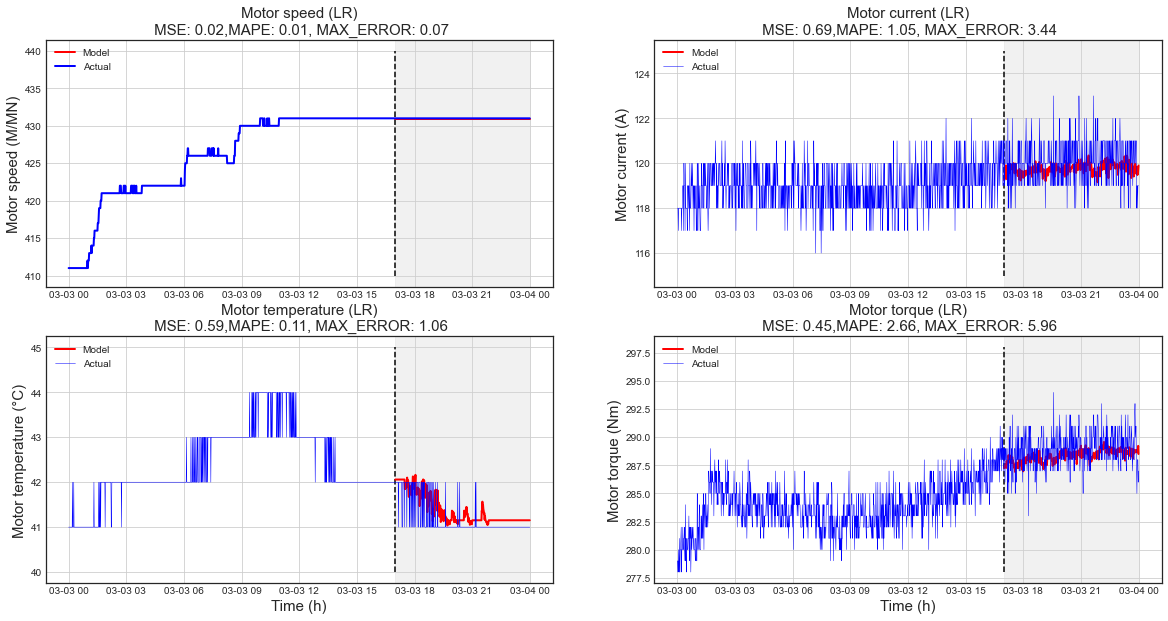

In [50]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_lr_predictions, 
          cu_lr_predictions, 
          te_lr_predictions, 
          nm_lr_predictions,
          'LR', 
          sd_lr_mse, sd_lr_mape, sd_lr_maxerror, 
          cu_lr_mse, cu_lr_mape, cu_lr_maxerror,
          te_lr_mse, te_lr_mape, te_lr_maxerror, 
          nm_lr_mse, nm_lr_mape, nm_lr_maxerror,
          predictive_mode=True)

## Gradient boosting on decision trees

### XGBoost

In [51]:
def xgboost_regression(data, start, end, trees):
    
    data_ = pd.DataFrame(data.copy())
    data_.columns = ["y"]

    for i in range(start, end):
        data_["lag_{}".format(i)] = data_.y.shift(i)    
    
    y = data_.dropna().y
    X = data_.dropna().drop(['y'], axis=1)
    
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear',
        'verbosity' : 0
                            }
    
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, show_stdv=False, num_boost_round=trees)
    
    xgboost = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    prediction = xgboost.predict(dtest)
    forecast = pd.Series(prediction, index=y_test.index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(y_test.values, forecast.values)

    return forecast, mape, mse, maxerror

In [52]:
%%time

sd_xgb_predictions, sd_xgb_mape, sd_xgb_mse, sd_xgb_maxerror = xgboost_regression(data_ts_sd_m['Motor speed'], 200, 220, 20)
cu_xgb_predictions, cu_xgb_mape, cu_xgb_mse, cu_xgb_maxerror = xgboost_regression(data_ts_cu_m['Current'], 20, 40, 10)
te_xgb_predictions, te_xgb_mape, te_xgb_mse, te_xgb_maxerror = xgboost_regression(data_ts_te_m['Temperature'], 5, 15, 100)
nm_xgb_predictions, nm_xgb_mape, nm_xgb_mse, nm_xgb_maxerror = xgboost_regression(data_ts_nm_m['Torque'], 20, 40, 10)

Wall time: 1.2 s


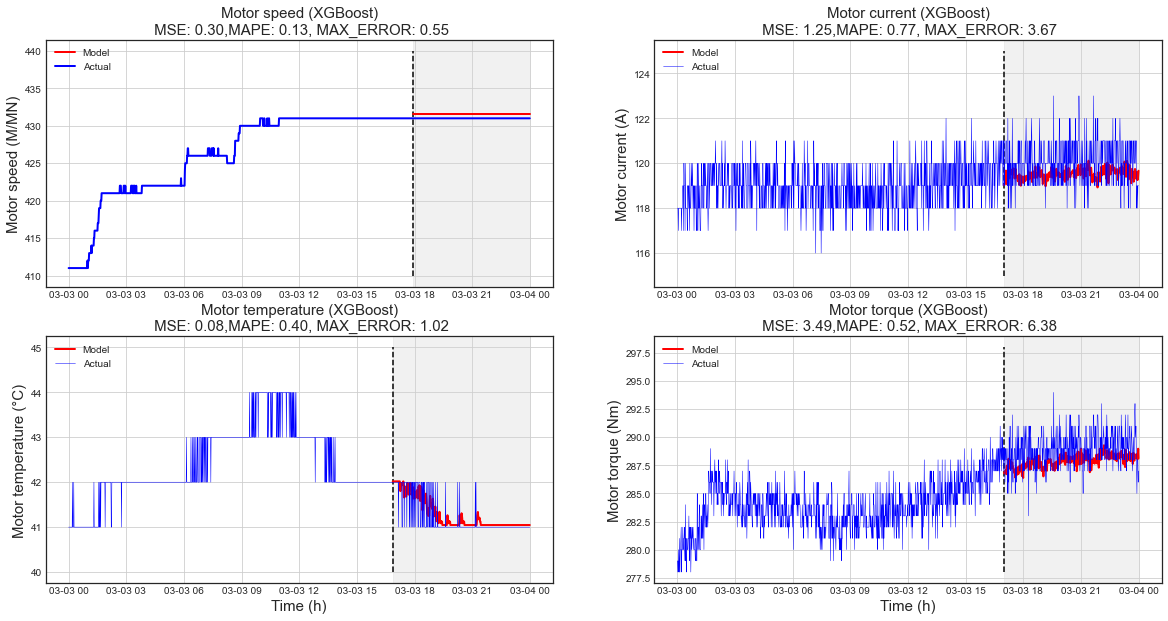

In [53]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_xgb_predictions, 
          cu_xgb_predictions, 
          te_xgb_predictions, 
          nm_xgb_predictions, 
          'XGBoost', 
          sd_xgb_mse, sd_xgb_mape, sd_xgb_maxerror, 
          cu_xgb_mse, cu_xgb_mape, cu_xgb_maxerror,
          te_xgb_mse, te_xgb_mape, te_xgb_maxerror, 
          nm_xgb_mse, nm_xgb_mape, nm_xgb_maxerror,
          predictive_mode=True)

### CatBoost

In [54]:
def catboost_regression(data, start, end):
    
    data_ = pd.DataFrame(data.copy())
    data_.columns = ["y"]

    for i in range(start, end):
        data_["lag_{}".format(i)] = data_.y.shift(i)    
    
    y = data_.dropna().y
    X = data_.dropna().drop(['y'], axis=1)
    
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    catboost = CatBoostRegressor(iterations=100, depth=4, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)
    
    catboost.fit(X_train_scaled, y_train, verbose=0)
    
    prediction = catboost.predict(X_test_scaled)
    forecast = pd.Series(prediction, index=y_test.index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(y_test.values, forecast.values)

    return forecast, mape, mse, maxerror

In [55]:
%%time

sd_cat_predictions, sd_cat_mape, sd_cat_mse, sd_cat_maxerror = catboost_regression(data_ts_sd_m['Motor speed'], 20, 40)
cu_cat_predictions, cu_cat_mape, cu_cat_mse, cu_cat_maxerror = catboost_regression(data_ts_cu_m['Current'], 20, 40)
te_cat_predictions, te_cat_mape, te_cat_mse, te_cat_maxerror = catboost_regression(data_ts_te_m['Temperature'], 20, 40)
nm_cat_predictions, nm_cat_mape, nm_cat_mse, nm_cat_maxerror = catboost_regression(data_ts_nm_m['Torque'], 20, 40)

Wall time: 2.14 s


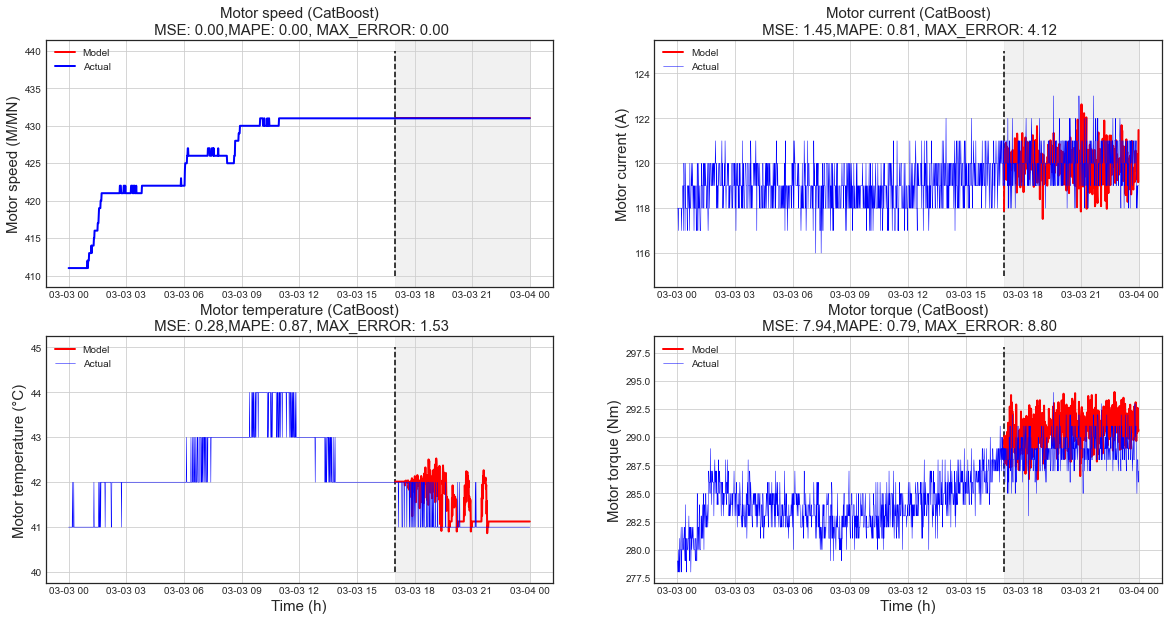

In [56]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_cat_predictions, 
          cu_cat_predictions, 
          te_cat_predictions, 
          nm_cat_predictions, 
          'CatBoost', 
          sd_cat_mse, sd_cat_mape, sd_cat_maxerror, 
          cu_cat_mse, cu_cat_mape, cu_cat_maxerror,
          te_cat_mse, te_cat_mape, te_cat_maxerror, 
          nm_cat_mse, nm_cat_mape, nm_cat_maxerror,
          predictive_mode=True)

### LightGBM

In [57]:
def lgbm_regression(data, start, end, trees=10):
    
    data_ = pd.DataFrame(data.copy())
    data_.columns = ["y"]

    for i in range(start, end):
        data_["lag_{}".format(i)] = data_.y.shift(i)    
    
    y = data_.dropna().y
    X = data_.dropna().drop(['y'], axis=1)
    
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    params = {"objective" : "regression", "metric" : "mae", 'n_estimators':20000, 
              "learning_rate" : 0.1, 
               "num_threads" : 4,
              "colsample_bytree" : 0.7
             }
    
    lgbTrain = lgb.Dataset(X_train_scaled, label=y_train)
    
    model = lgb.train(params, lgbTrain, verbose_eval=0)
    
    prediction = model.predict(X_test_scaled)
    forecast = pd.Series(prediction, index=y_test.index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(y_test.values, forecast.values)

    return forecast, mape, mse, maxerror

In [58]:
%%time

sd_lgbm_predictions, sd_lgbm_mape, sd_lgbm_mse, sd_lgbm_maxerror = lgbm_regression(data_ts_sd_m['Motor speed'], 20, 40)
cu_lgbm_predictions, cu_lgbm_mape, cu_lgbm_mse, cu_lgbm_maxerror = lgbm_regression(data_ts_cu_m['Current'], 20, 40)
te_lgbm_predictions, te_lgbm_mape, te_lgbm_mse, te_lgbm_maxerror = lgbm_regression(data_ts_te_m['Temperature'], 20, 40)
nm_lgbm_predictions, nm_lgbm_mape, nm_lgbm_mse, nm_lgbm_maxerror = lgbm_regression(data_ts_nm_m['Torque'], 20, 40)

Wall time: 42.8 s


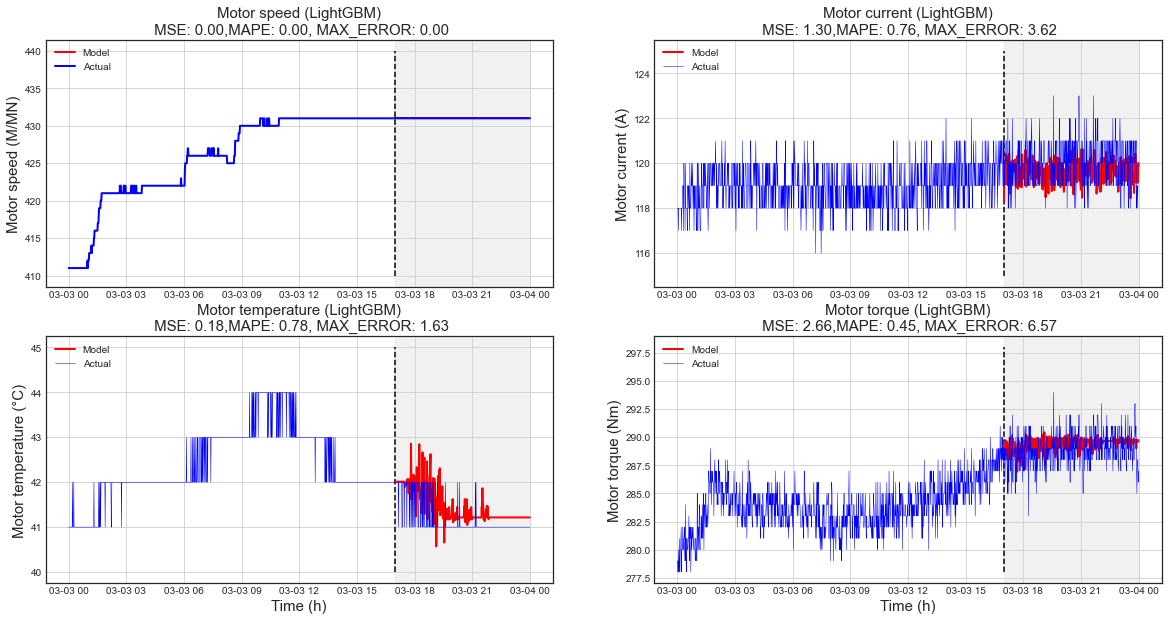

In [59]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_lgbm_predictions, 
          cu_lgbm_predictions, 
          te_lgbm_predictions, 
          nm_lgbm_predictions, 
          'LightGBM', 
          sd_lgbm_mse, sd_lgbm_mape, sd_lgbm_maxerror, 
          cu_lgbm_mse, cu_lgbm_mape, cu_lgbm_maxerror,
          te_lgbm_mse, te_lgbm_mape, te_lgbm_maxerror, 
          nm_lgbm_mse, nm_lgbm_mape, nm_lgbm_maxerror,
          predictive_mode=True)

## Facebook Prophet

In [60]:
def fbp(data, predictions=432):
    
    data_ = data
    data = data.reset_index()
    data.columns = ['ds', 'y']
    train_data = data[:-predictions]
    
    model = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative')
    
    model.fit(train_data)
    future = model.make_future_dataframe(periods=predictions, freq='T')
    forecast = model.predict(future)
    
    forecast['fact'] = data['y'].reset_index(drop = True)
    
    y_pred = forecast['yhat'].values
    y_true = forecast['fact'].values
    
    final_forecast = pd.Series(y_pred[len(y_pred)-predictions:], index=data_[len(y_pred)-predictions:].index)
    
    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(y_true[len(y_pred)-predictions:], final_forecast.values)

    return final_forecast, mape, mse, maxerror

In [61]:
%%time

sd_fbp_predictions, sd_fbp_mape, sd_fbp_mse, sd_fbp_maxerror = fbp(data_ts_sd_m['Motor speed'])
cu_fbp_predictions, cu_fbp_mape, cu_fbp_mse, cu_fbp_maxerror = fbp(data_ts_cu_m['Current'])
te_fbp_predictions, te_fbp_mape, te_fbp_mse, te_fbp_maxerror = fbp(data_ts_te_m['Temperature'])
nm_fbp_predictions, nm_fbp_mape, nm_fbp_mse, nm_fbp_maxerror = fbp(data_ts_nm_m['Torque'])

Wall time: 28.1 s


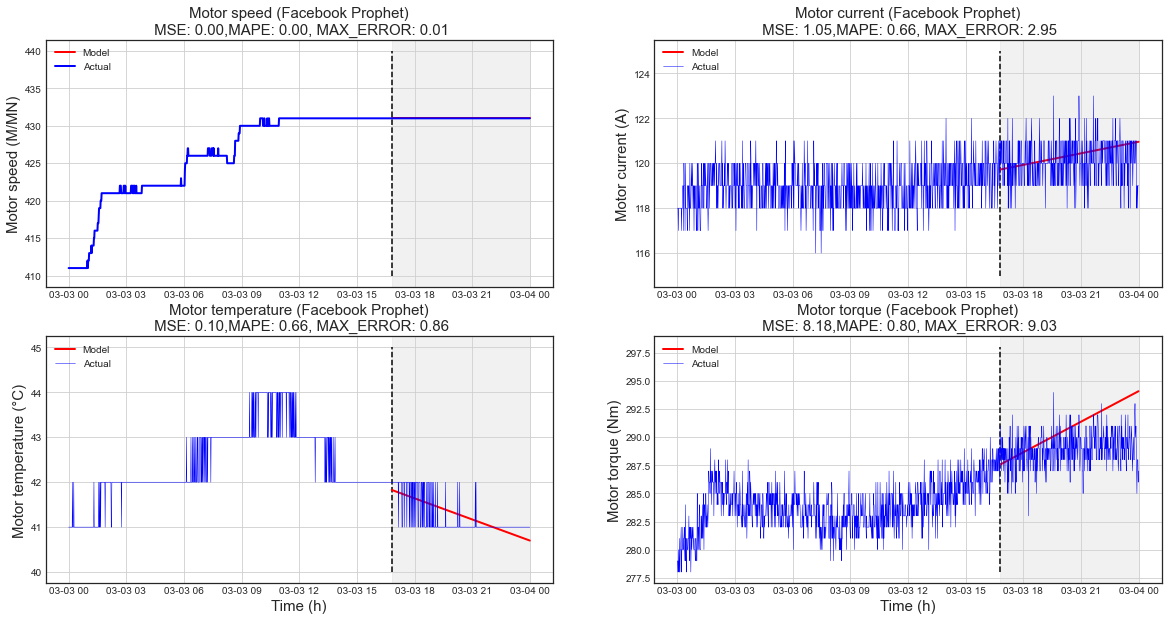

In [62]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_fbp_predictions, 
          cu_fbp_predictions, 
          te_fbp_predictions, 
          nm_fbp_predictions, 
          'Facebook Prophet', 
          sd_fbp_mse, sd_fbp_mape, sd_fbp_maxerror, 
          cu_fbp_mse, cu_fbp_mape, cu_fbp_maxerror,
          te_fbp_mse, te_fbp_mape, te_fbp_maxerror, 
          nm_fbp_mse, nm_fbp_mape, nm_fbp_maxerror,
          predictive_mode=True)

## Amazon Gluon TS 

In [76]:
def gluon_ts(data, cell_type='gru', epochs=30, batch_size=1, num_batches_per_epoch=1):
    
    train, test = split(data)
    
    data = ListDataset([{
        "start": train.index[0],
        "target": train[:len(train)].squeeze()
    }],
                              freq="T")

    estimator = DeepAREstimator(
        freq="T", 
        prediction_length=len(test), 
        cell_type=cell_type,
        trainer=Trainer(epochs=epochs))
    
    predictor = estimator.train(training_data=data)
    prediction = next(predictor.predict(data))
    
    forecast = pd.Series(prediction.mean, index=test.index)

    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(test.values, forecast.values)
    
    pred = forecast[:len(forecast)-1]
     
    return pred, mape, mse, maxerror

In [77]:
%%time

sd_gluon_predictions, sd_gluon_mape, sd_gluon_mse, sd_gluon_maxerror = gluon_ts(data_ts_sd_m)
cu_gluon_predictions, cu_gluon_mape, cu_gluon_mse, cu_gluon_maxerror = gluon_ts(data_ts_cu_m)
te_gluon_predictions, te_gluon_mape, te_gluon_mse, te_gluon_maxerror = gluon_ts(data_ts_te_m)
nm_gluon_predictions, nm_gluon_mape, nm_gluon_mse, nm_gluon_maxerror = gluon_ts(data_ts_nm_m)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|                                                              | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 18724
100%|████████████████████| 50/50 [01:04<00:00,  1.29s/it, epoch=1/30, avg_epoch_loss=7.19]
INFO:gluonts.trainer:Epoch[0] Elapsed time 64.367 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=7.190874
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|█████████████████████| 50/50 [00:51<00:00,  1.04s/it, epoch=2/30, avg_epoch_loss=4.1]
INFO:gluonts.trainer:Epoch[1] Elapsed time 51.982 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=4.099348
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|████████████████████| 50/50 [00:50<00:00,  1.01s/it, epoch=3/30, avg_epoch_loss=3.69]
INFO:gluonts.trainer:Epoch[2] Elapsed time 50.708 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=3.691356
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|████████████████████| 50/50 [00:53<00:00,  1.07s/it, epoch=4/30, avg_epoch_loss=3.52]
INFO:gluonts.traine

INFO:gluonts.trainer:Epoch[29] Evaluation metric 'epoch_loss'=3.055472
INFO:gluonts.trainer:Loading parameters from best epoch (29)
INFO:gluonts.trainer:Final loss: 3.0554715061187743 (occurred at epoch 29)
INFO:gluonts.trainer:End model training
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|                                                              | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 18724
100%|████████████████████| 50/50 [01:03<00:00,  1.28s/it, epoch=1/30, avg_epoch_loss=3.16]
INFO:gluonts.trainer:Epoch[0] Elapsed time 63.862 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=3.160361
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|████████████████████| 50/50 [00:51<00:00,  1.03s/it, epoch=2/30, avg_epoch_loss=2.25]
INFO:gluonts.trainer:Epoch[1] Elapsed time 51.693 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.247342
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|████████████████████| 50/50 [00:49<00:00,  1.01it/s, epoch=3/30, avg_epoch_loss=2.08]
INFO:gluonts.trainer:Epoch[2] Elapsed time 49.622 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=2.084260
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|████████████████████| 50/50 [00:48<00:00,  1.03it/s, epoch=4/30, avg_epoch_loss=2.01]
INFO:gluonts.traine

INFO:gluonts.trainer:Loading parameters from best epoch (26)
INFO:gluonts.trainer:Final loss: 1.6447988104820253 (occurred at epoch 26)
INFO:gluonts.trainer:End model training
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|                                                              | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 18724
100%|████████████████████| 50/50 [01:13<00:00,  1.47s/it, epoch=1/30, avg_epoch_loss=3.62]
INFO:gluonts.trainer:Epoch[0] Elapsed time 73.464 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=3.623490
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|████████████████████| 50/50 [00:59<00:00,  1.20s/it, epoch=2/30, avg_epoch_loss=2.33]
INFO:gluonts.trainer:Epoch[1] Elapsed time 59.923 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=2.328042
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|████████████████████| 50/50 [01:00<00:00,  1.21s/it, epoch=3/30, avg_epoch_loss=1.82]
INFO:gluonts.trainer:Epoch[2] Elapsed time 60.737 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.819694
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|████████████████████| 50/50 [01:01<00:00,  1.22s/it, epoch=4/30, avg_epoch_loss=2.03]
INFO:gluonts.traine

INFO:gluonts.trainer:Loading parameters from best epoch (29)
INFO:gluonts.trainer:Final loss: 0.6347900694608688 (occurred at epoch 29)
INFO:gluonts.trainer:End model training
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|                                                              | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 18724
100%|████████████████████| 50/50 [01:12<00:00,  1.45s/it, epoch=1/30, avg_epoch_loss=5.36]
INFO:gluonts.trainer:Epoch[0] Elapsed time 72.664 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=5.360337
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|████████████████████| 50/50 [00:56<00:00,  1.13s/it, epoch=2/30, avg_epoch_loss=4.28]
INFO:gluonts.trainer:Epoch[1] Elapsed time 56.304 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=4.282773
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|████████████████████| 50/50 [00:57<00:00,  1.16s/it, epoch=3/30, avg_epoch_loss=3.77]
INFO:gluonts.trainer:Epoch[2] Elapsed time 57.965 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=3.768265
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|████████████████████| 50/50 [00:54<00:00,  1.09s/it, epoch=4/30, avg_epoch_loss=3.21]
INFO:gluonts.traine

INFO:gluonts.trainer:Loading parameters from best epoch (29)
INFO:gluonts.trainer:Final loss: 2.439091100692749 (occurred at epoch 29)
INFO:gluonts.trainer:End model training


Wall time: 1h 47min 44s


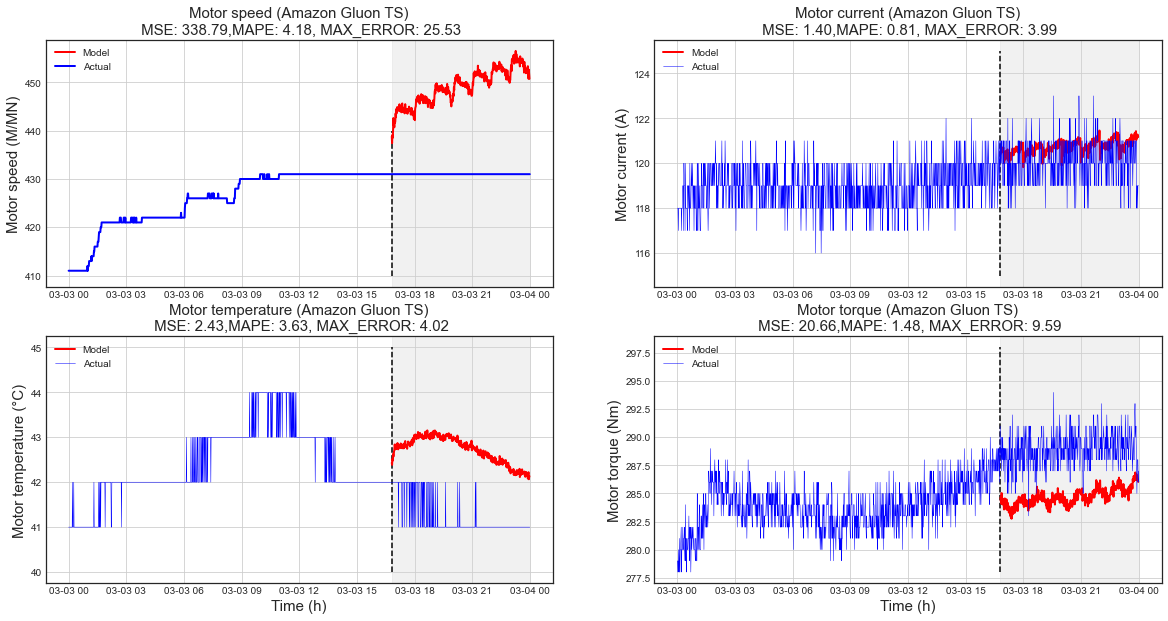

In [78]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_gluon_predictions, 
          cu_gluon_predictions, 
          te_gluon_predictions, 
          nm_gluon_predictions, 
          'Amazon Gluon TS', 
          sd_gluon_mse, sd_gluon_mape, sd_gluon_maxerror, 
          cu_gluon_mse, cu_gluon_mape, cu_gluon_maxerror,
          te_gluon_mse, te_gluon_mape, te_gluon_maxerror, 
          nm_gluon_mse, nm_gluon_mape, nm_gluon_maxerror,
          predictive_mode=True)

## LSTM

In [79]:
def get_data(f_dataset, look_back):
    datax = []
    datay = []
    for i in range(len(f_dataset)-look_back-1):
        a = f_dataset[i:(i+look_back), 0]
        datax.append(a)
        datay.append(f_dataset[i+look_back, 0])
    return np.array(datax), np.array(datay)

def lstm(dataset, epochs=20, batch_size=1, activation_lstm='tanh', activation_dense='relu'):
    
    data = np.array(dataset).reshape(-1,1)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    
    train, test = split(data)
    
    look_back = 1
    x_train, y_train = get_data(train, look_back)
    x_test, y_test = get_data(test, look_back)
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(16, activation=activation_lstm, input_shape = (1,1)))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(1, activation=activation_dense))

    model.compile(optimizer='adam', loss = 'mean_squared_error') 
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
    
    y_pred = model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred)
    
    y_test = np.array(y_test)
    y_test = y_test.reshape(-1,1)
    y_test = scaler.inverse_transform(y_test)

    forecast = pd.DataFrame(y_pred, index=dataset[len(dataset)-len(y_pred):].index)

    mape, evs, maxerror, mae, mse, msle, r2, mpd = quality_metrics(y_test, y_pred)

    return forecast, mape, mse, maxerror

In [80]:
%%time

sd_lstm_predictions, sd_lstm_mape, sd_lstm_mse, sd_lstm_maxerror = lstm(data_ts_sd_m['Motor speed'])
cu_lstm_predictions, cu_lstm_mape, cu_lstm_mse, cu_lstm_maxerror = lstm(data_ts_cu_m['Current'])
te_lstm_predictions, te_lstm_mape, te_lstm_mse, te_lstm_maxerror = lstm(data_ts_te_m['Temperature'])
nm_lstm_predictions, nm_lstm_mape, nm_lstm_mse, nm_lstm_maxerror = lstm(data_ts_nm_m['Torque'])

Train on 1007 samples
Epoch 1/20


1007/1007 [==============================] - 5s 5ms/sample - loss: 0.1164
Epoch 2/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0242
Epoch 3/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0125
Epoch 4/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0104
Epoch 5/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0076
Epoch 6/20
1007/1007 [==============================] - 4s 4ms/sample - loss: 0.0070
Epoch 7/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0061
Epoch 8/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0050
Epoch 9/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0041
Epoch 10/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0039
Epoch 11/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0030
Epoch 12/20
1007/1007 [==============================] - 2s 2ms/sample - l

1007/1007 [==============================] - 5s 5ms/sample - loss: 0.0370
Epoch 2/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0210
Epoch 3/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0198
Epoch 4/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0199
Epoch 5/20
1007/1007 [==============================] - 4s 4ms/sample - loss: 0.0200
Epoch 6/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0199
Epoch 7/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0196
Epoch 8/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0193
Epoch 9/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0188
Epoch 10/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0191
Epoch 11/20
1007/1007 [==============================] - 5s 5ms/sample - loss: 0.0190
Epoch 12/20
1007/1007 [==============================] - 3s 3ms/sample - l

1007/1007 [==============================] - 4s 4ms/sample - loss: 0.0631
Epoch 2/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0220
Epoch 3/20
1007/1007 [==============================] - 4s 4ms/sample - loss: 0.0204
Epoch 4/20
1007/1007 [==============================] - 6s 6ms/sample - loss: 0.0215
Epoch 5/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0187
Epoch 6/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0183
Epoch 7/20
1007/1007 [==============================] - 4s 4ms/sample - loss: 0.0179
Epoch 8/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0172
Epoch 9/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0168
Epoch 10/20
1007/1007 [==============================] - 2s 2ms/sample - loss: 0.0172
Epoch 11/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0167
Epoch 12/20
1007/1007 [==============================] - 3s 3ms/sample - l

1007/1007 [==============================] - 4s 3ms/sample - loss: 0.0204
Epoch 2/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0148
Epoch 3/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0141
Epoch 4/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0138
Epoch 5/20
1007/1007 [==============================] - 3s 2ms/sample - loss: 0.0131
Epoch 6/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0129
Epoch 7/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0126
Epoch 8/20
1007/1007 [==============================] - 7s 7ms/sample - loss: 0.0128
Epoch 9/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0128
Epoch 10/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0127
Epoch 11/20
1007/1007 [==============================] - 3s 3ms/sample - loss: 0.0125
Epoch 12/20
1007/1007 [==============================] - 2s 2ms/sample - l

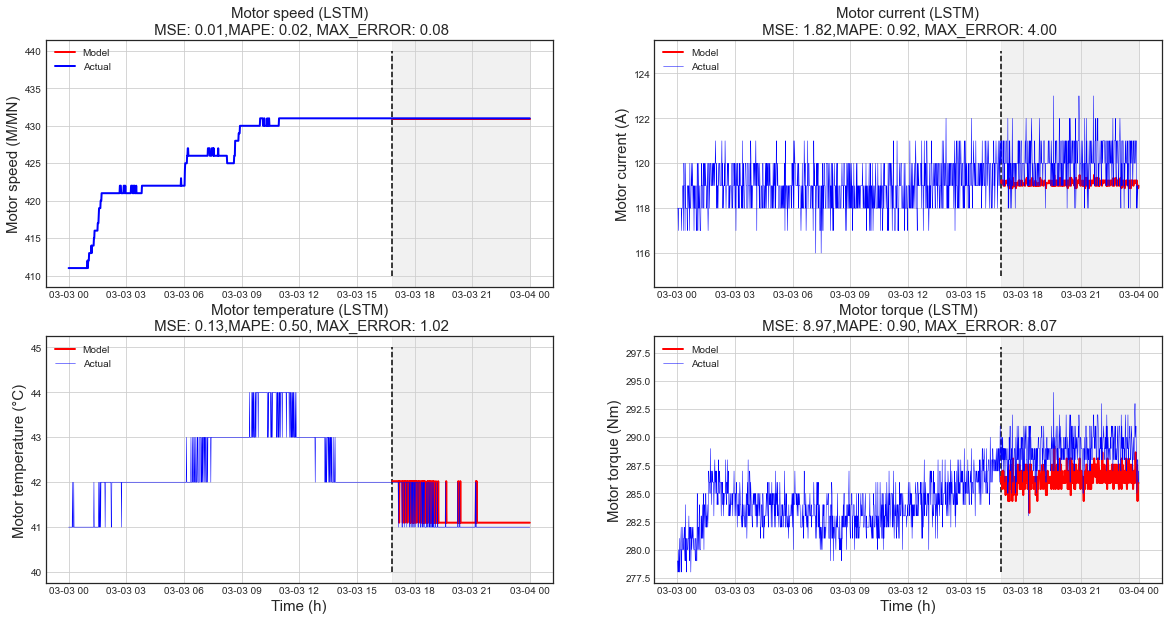

In [81]:
plotModel(data_ts_sd_m['Motor speed'], 
          data_ts_cu_m['Current'], 
          data_ts_te_m['Temperature'], 
          data_ts_nm_m['Torque'], 
          sd_lstm_predictions, 
          cu_lstm_predictions, 
          te_lstm_predictions, 
          nm_lstm_predictions, 
          'LSTM', 
          sd_lstm_mse, sd_lstm_mape, sd_lstm_maxerror, 
          cu_lstm_mse, cu_lstm_mape, cu_lstm_maxerror,
          te_lstm_mse, te_lstm_mape, te_lstm_maxerror, 
          nm_lstm_mse, nm_lstm_mape, nm_lstm_maxerror,
          predictive_mode=True)